In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/Finaldataa.csv')

In [ ]:
df["category"].unique()

array(['bags', 'trousers', 'dress', 'skirt', 'shirt', 'jacket', 't_shirt',
       'socks', 'shoes'], dtype=object)

In [ ]:
label_encoder = LabelEncoder()
df["category"] = label_encoder.fit_transform(df["category"])

In [ ]:
df=df[["p_img","category"]]

In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

class URLImageGenerator(Sequence):
    def __init__(self, df, batch_size=32, img_size=(224, 224), shuffle=True, augment=False):
        self.df = df.copy()
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

        self.datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode="nearest"
        ) if augment else ImageDataGenerator()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__load_batch(batch_data)
        return X, y

    def __load_batch(self, batch_data):
        images, labels = [], []
        for _, row in batch_data.iterrows():
            url, label = row["p_img"], row["category"]
            if url.startswith("//"):
                url = "https:" + url
            img = self.__load_image(url)
            if img is not None:
                images.append(img)
                labels.append(label)
        X = np.array(images, dtype=np.float32)
        y = tf.keras.utils.to_categorical(labels, num_classes=len(set(self.df["category"])))
        return X, y

    """def __load_image(self, url):
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img = img.resize(self.img_size)
            img = np.array(img) / 255.0
            if self.augment:
                img = self.datagen.random_transform(img)
            return img
        except Exception as e:
            print(f"Error loading image from {url}: {e}")
            return None"""
    def __load_image(self, url):

      try:

        response = requests.get(url, timeout=5)
        response.raise_for_status()  # Ensure it's a successful response
        img = Image.open(BytesIO(response.content)).convert("RGB")
      except Exception as e:
        print(f"Error loading image from {url}: {e}")
        img = Image.new("RGB", self.img_size, (255, 255, 255))  # White blank image

      img = img.resize(self.img_size)
      img = np.array(img) / 255.0
      if self.augment:
        img = self.datagen.random_transform(img)
      return img


    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

# Encode labels
label_encoder = LabelEncoder()
df["category"] = label_encoder.fit_transform(df["category"])

df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df["category"], random_state=42)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp["category"], random_state=42)

batch_size = 32
img_size = (224, 224)

train_generator = URLImageGenerator(df_train, batch_size=batch_size, img_size=img_size, shuffle=True, augment=True)
valid_generator = URLImageGenerator(df_valid, batch_size=batch_size, img_size=img_size, shuffle=False, augment=False)
test_generator = URLImageGenerator(df_test, batch_size=batch_size, img_size=img_size, shuffle=False, augment=False)

base_model = InceptionV3(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(len(set(df["category"])), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compile again
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_128 (Conv2D)       │ (None, None, None, 32) │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_128   │ (None, None, None, 32) │             96 │ conv2d_128[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_127            │ (None, None, None, 32) │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_129 (Conv2D)       │ (None, None, None, 32) │          9,216 │ activation_127[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_129   │ (None, None, None, 32) │             96 │ conv2d_129[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_128            │ (None, None, None, 32) │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_130 (Conv2D)       │ (None, None, None, 64) │         18,432 │ activation_128[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_130   │ (None, None, None, 64) │            192 │ conv2d_130[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_129            │ (None, None, None, 64) │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, None, None, 64) │              0 │ activation_129[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_131 (Conv2D)       │ (None, None, None, 80) │          5,120 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_131   │ (None, None, None, 80) │            240 │ conv2d_131[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_130            │ (None, None, None, 80) │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_132 (Conv2D)  

 Total params: 23,910,185 (91.21 MB)

 Trainable params: 23,875,753 (91.08 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["category"]),
    y=df["category"]
)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    verbose=1
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.4321 - loss: 1.8405 - val_accuracy: 0.8236 - val_loss: 0.7130
Epoch 2/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.7726 - loss: 0.8225 - val_accuracy: 0.8931 - val_loss: 0.4140
Epoch 3/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.8253 - loss: 0.5539 - val_accuracy: 0.9028 - val_loss: 0.3367
Epoch 4/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.8638 - loss: 0.4083 - val_accuracy: 0.9069 - val_loss: 0.3057
Epoch 5/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.8879 - loss: 0.3232 - val_accuracy: 0.9299 - val_loss: 0.2471
Epoch 6/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 301s 1s/step - accuracy: 0.8927 - loss: 0.2859 - val_accuracy: 0.9299 - val_loss: 0.2357
Epoch 7/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.9074 - loss: 0.2592 - val_accuracy: 0.9257 - val_loss: 0.2290
Epoch 8/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.9187 - loss: 0.2167 - val_accu

In [ ]:
model.save("fashion_classifier2.h5")

In [ ]:

import numpy as np
import requests
from PIL import Image
from io import BytesIO
import tensorflow as tf

def preprocess_image(url, img_size=(224, 224)):
    try:
        if url.startswith("//"):
            url = "https:" + url  # Fix incomplete URLs

        response = requests.get(url, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        img = Image.new("RGB", img_size, (255, 255, 255))  # White blank image for errors

    img = img.resize(img_size)
    img = np.array(img) / 255.0  # Normalize to [0,1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


In [ ]:

test_url = "https://th.bing.com/th/id/OIP.MSvaqDdCahCRTFmNcIsxZAHaFh?rs=1&pid=ImgDetMain"


test_image = preprocess_image(test_url)


predictions = model.predict(test_image)


predicted_index = np.argmax(predictions)


predicted_label = label_encoder.inverse_transform([predicted_index])[0]

print(f"Predicted Category: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Category: bags


In [ ]:
test_urls = [
    "https://th.bing.com/th/id/OIP.q_24yDH6d5jSeDjsoOAS4wHaHa?rs=1&pid=ImgDetMain",
    "https://th.bing.com/th/id/OIP.vkqAHF9T41ykWZbpA5v1AAHaJ4?rs=1&pid=ImgDetMain",
    "https://th.bing.com/th/id/OIP.fsQMwNpaV6Cf-0dGnkWfzQHaJr?rs=1&pid=ImgDetMain"
]

for url in test_urls:
    img = preprocess_image(url)
    pred = model.predict(img)
    label = label_encoder.inverse_transform([np.argmax(pred)])[0]
    print(f"Image: {url} --> Predicted: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image: https://th.bing.com/th/id/OIP.q_24yDH6d5jSeDjsoOAS4wHaHa?rs=1&pid=ImgDetMain --> Predicted: skirt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Image: https://th.bing.com/th/id/OIP.vkqAHF9T41ykWZbpA5v1AAHaJ4?rs=1&pid=ImgDetMain --> Predicted: skirt
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image: https://th.bing.com/th/id/OIP.fsQMwNpaV6Cf-0dGnkWfzQHaJr?rs=1&pid=ImgDetMain --> Predicted: socks


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


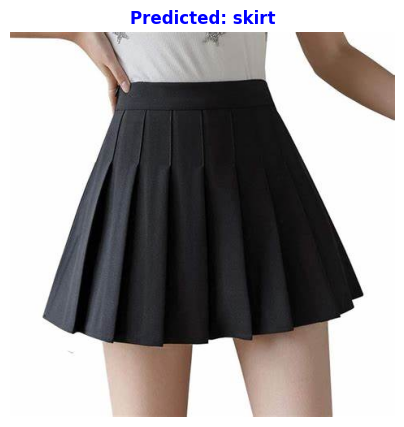

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


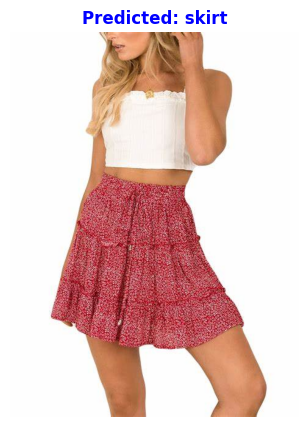

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


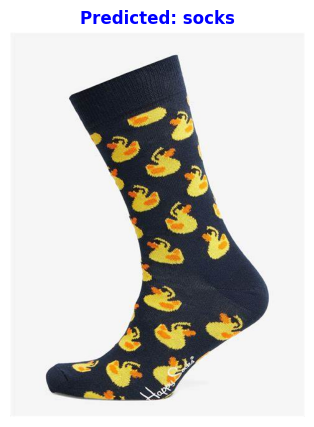

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO

test_urls = [
    "https://th.bing.com/th/id/OIP.q_24yDH6d5jSeDjsoOAS4wHaHa?rs=1&pid=ImgDetMain",
    "https://th.bing.com/th/id/OIP.vkqAHF9T41ykWZbpA5v1AAHaJ4?rs=1&pid=ImgDetMain",
    "https://th.bing.com/th/id/OIP.fsQMwNpaV6Cf-0dGnkWfzQHaJr?rs=1&pid=ImgDetMain"
]
def show_prediction(url):
    img = preprocess_image(url)  # Preprocess the image
    pred = model.predict(img)  # Get predictions
    label = label_encoder.inverse_transform([np.argmax(pred)])[0]  # Get category label


    response = requests.get(url, timeout=5)
    image_display = Image.open(BytesIO(response.content))

    # Display the image with prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image_display)
    plt.axis("off")
    plt.title(f"Predicted: {label}", fontsize=12, fontweight="bold", color="blue")
    plt.show()

for url in test_urls:
    show_prediction(url)
